# Start-to-Finish Example: $\text{GiRaFFE_HO}$ 1D tests

### Author: Patrick Nelson

### Adapted from [Start-to-Finish Example: Head-On Black Hole Collision](Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide.ipynb)

## This module implements a basic GRFFE code to evolve one-dimensional GRFFE waves.

### NRPy+ Source Code for this module: 
1. [GiRaFFEfood_HO/GiRaFFEfood_HO_1D_tests.py](../edit/GiRaFFEfood_HO/GiRaFFEfood_HO_1D_tests.py); [\[**tutorial**\]](Tutorial-GiRaFFEfood_HO_1D_tests.ipynb): Aligned rotator initial data, sets all FFE variables in a Cartesian basis.
1. [GiRaFFE_HO/GiRaFFE_Higher_Order.py](../edit/GiRaFFE_HO/GiRaFFE_Higher_Order.py); [\[**tutorial**\]](Tutorial-GiRaFFE_Higher_Order.ipynb): Generates the right-hand sides for the GRFFE evolution equations in Cartesian coordinates.
We will also borrow C code from the ETK implementation of $\text{GiRaFFE_HO}$

Here we use NRPy+ to generate the C source code necessary to set up initial data for a model neutron star (see [the original GiRaFFE paper](https://arxiv.org/pdf/1704.00599.pdf)). Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. (**Step 2** below) <font color='green'>Set gridfunction values to initial data (**[documented in previous start-to-finish module](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_two_BH_initial_data.ipynb)**).</font>
1. Evolve the initial data forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. (**Step 3A** below) <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. (**Step 4** below) Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
1. (**Step 3B** below) At the end of each iteration in time, output the <font color='green'>FFE variables</font>. (This is in Step 3B, because Step 4 requires that *all* gridfunctions be defined.)
1. Repeat above steps at two numerical resolutions to confirm convergence to the expected value.

In [1]:
# First we import needed core NRPy+ modules
from outputC import *
import NRPy_param_funcs as par
import grid as gri
import loop as lp
import indexedexp as ixp
import finite_difference as fin
import reference_metric as rfm

# Set the finite differencing order to 4.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 2)

# Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","Cartesian")
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Then we set the phi axis to be the symmetry axis; i.e., axis "2", corresponding to the i2 direction. 
#      This sets all spatial derivatives in the phi direction to zero.
#par.set_parval_from_str("indexedexp::symmetry_axes","2") # Let's not deal with this yet.

# Choices are: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"

# Generate timestepping code. As described above the Table of Contents, this is a 3-step process:
#       3.A: Evaluate RHSs (RHS_string)
#       3.B: Apply boundary conditions (post_RHS_string, pt 1)
#       3.C: Enforce det(gammabar) = det(gammahat) constraint (post_RHS_string, pt 2)
import MoLtimestepping.C_Code_Generation as MoL
from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
RK_order  = Butcher_dict[RK_method][1]
MoL.MoL_C_Code_Generation(RK_method, 
    RHS_string = "rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, RK_INPUT_GFS, aux_gfs, RK_OUTPUT_GFS);",
    post_RHS_string = """
apply_bcs(Nxx, Nxx_plus_2NGHOSTS, RK_OUTPUT_GFS);
//apply_bcs_EXACT(Nxx,Nxx_plus_2NGHOSTS,xx,n,dt,RK_OUTPUT_GFS,aux_gfs);
// Run the conservative to primitive solvers after the boundary condition routines.
driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, RK_OUTPUT_GFS, aux_gfs);
GiRaFFE_HO_conserv_to_prims_FFE(Nxx, Nxx_plus_2NGHOSTS, dxx,xx, RK_OUTPUT_GFS, aux_gfs);\n""")

#################
# Next output C headers related to the numerical grids we just set up:
#################

# Create directories for the thorn if they don't exist.
!mkdir GiRaFFE_standalone 2>/dev/null # 2>/dev/null: Don't throw an error if the directory already exists.

# First output the coordinate bounds xxmin[] and xxmax[]:
with open("GiRaFFE_standalone/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")

# Next output the proper distance between gridpoints in given coordinate system.
#     This is used to find the minimum timestep.
dxx     = ixp.declarerank1("dxx",DIM=3)
ds_dirn = rfm.ds_dirn(dxx)
outputC([ds_dirn[0],ds_dirn[1],ds_dirn[2]],["ds_dirn0","ds_dirn1","ds_dirn2"],"GiRaFFE_standalone/ds_dirn.h")

# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "GiRaFFE_standalone/xxCart.h")

Wrote to file "GiRaFFE_standalone/ds_dirn.h"
Wrote to file "GiRaFFE_standalone/xxCart.h"


## Step 2A: Import Alfv&eacute;n Wave initial data C function

The [GiRaFFEfood_HO.GiRaFFEfood_HO_1D_tests.py](../edit/GiRaFFEfood_HO/GiRaFFEfood_HO_AlignedRotator.py) NRPy+ module does the following:

1. Set up Alfv&eacute;n Wave initial data quantities in the **Cartesian basis**, as [documented here](Tutorial-GiRaFFEfood_HO_1D_tests.ipynb). 


In [2]:
import GiRaFFEfood_HO.GiRaFFEfood_HO_1D_tests as gf1D
gf1D.GiRaFFEfood_HO_1D_tests()

# Step 2: Create the C code output kernel.
#BU = ixp.register_gridfunctions_for_single_rank1("AUX","BU")
GiRaFFEfood_A_v_to_print_left   = [\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD0"),rhs=gf1D.AleftD[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD1"),rhs=gf1D.AleftD[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD2"),rhs=gf1D.AleftD[2]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU0"),rhs=gf1D.ValenciavleftU[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU1"),rhs=gf1D.ValenciavleftU[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU2"),rhs=gf1D.ValenciavleftU[2]),\
                                  ]
GiRaFFEfood_A_v_to_print_center = [\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD0"),rhs=gf1D.AcenterD[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD1"),rhs=gf1D.AcenterD[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD2"),rhs=gf1D.AcenterD[2]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU0"),rhs=gf1D.ValenciavcenterU[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU1"),rhs=gf1D.ValenciavcenterU[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU2"),rhs=gf1D.ValenciavcenterU[2]),\
                                  ]
GiRaFFEfood_A_v_to_print_right  = [\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD0"),rhs=gf1D.ArightD[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD1"),rhs=gf1D.ArightD[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","AD2"),rhs=gf1D.ArightD[2]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU0"),rhs=gf1D.ValenciavrightU[0]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU1"),rhs=gf1D.ValenciavrightU[1]),\
                                   lhrh(lhs=gri.gfaccess("out_gfs","ValenciavU2"),rhs=gf1D.ValenciavrightU[2]),\
                                  ]

GiRaFFEfood_A_v_CKernel_left   = fin.FD_outputC("returnstring",GiRaFFEfood_A_v_to_print_left,   params="outCverbose=False")
GiRaFFEfood_A_v_CKernel_center = fin.FD_outputC("returnstring",GiRaFFEfood_A_v_to_print_center, params="outCverbose=False")
GiRaFFEfood_A_v_CKernel_right  = fin.FD_outputC("returnstring",GiRaFFEfood_A_v_to_print_right,  params="outCverbose=False")

# Format the code within a C loop over cctkGH
#GiRaFFEfood_A_v_looped = loop.loop(["i2","i1","i0"],["0","0","0"],["cctk_lsh[2]","cctk_lsh[1]","cctk_lsh[0]"],\
#                                   ["1","1","1"],["#pragma omp parallel for","",""],"",\
#                                   GiRaFFEfood_A_v_CKernel.replace("time","cctk_time"))

# Step 4: Write the C code kernel to file.
with open("GiRaFFE_standalone/GiRaFFEfood_A_v_1D_tests_left.h", "w") as file:
    file.write(str(GiRaFFEfood_A_v_CKernel_left))

with open("GiRaFFE_standalone/GiRaFFEfood_A_v_1D_tests_center.h", "w") as file:
    file.write(str(GiRaFFEfood_A_v_CKernel_center))

with open("GiRaFFE_standalone/GiRaFFEfood_A_v_1D_tests_right.h", "w") as file:
    file.write(str(GiRaFFEfood_A_v_CKernel_right))


initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_SQRT1_2
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::xmin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::xmax
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::ymin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::ymax
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::zmin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::zmax


## Step 2C: Import densitized Poynting flux initial data conversion C function

The [GiRaFFEfood_HO.GiRaFFEfood_HO.py](../edit/GiRaFFEfood_HO/GiRaFFEfood_HO.py) NRPy+ module does the following:

1. Set up Exact Wald initial data quantities in the **Cartesian basis**, as [documented here](Tutorial-GiRaFFEfood_HO_Aligned_Rotator.ipynb).
2. Convert initial magnetic fields and Valencia 3-velocities into densitized Poynting flux initial data.

We only use the second functionality here (for now).


In [3]:
# Step 2: Create the C code output kernel.
gri.glb_gridfcs_list = []
import GiRaFFEfood_HO.GiRaFFEfood_HO as gfho
gfho.GiRaFFEfood_HO_ID_converter()
# To best format this for the ETK, we'll need to register this gridfunction.
StildeD = ixp.register_gridfunctions_for_single_rank1("EVOL","StildeD")
GiRaFFE_S_to_print = [\
                      lhrh(lhs=gri.gfaccess("out_gfs","StildeD0"),rhs=gfho.StildeD[0]),\
                      lhrh(lhs=gri.gfaccess("out_gfs","StildeD1"),rhs=gfho.StildeD[1]),\
                      lhrh(lhs=gri.gfaccess("out_gfs","StildeD2"),rhs=gfho.StildeD[2]),\
                     ]

GiRaFFE_S_CKernel = fin.FD_outputC("returnstring",GiRaFFE_S_to_print,params="outCverbose=False")

# Format the code within a C loop over cctkGH
GiRaFFE_S_looped = lp.loop(["i2","i1","i0"],["0","0","0"],
                           ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],\
                           ["1","1","1"],["#pragma omp parallel for","",""],"",\
                           GiRaFFE_S_CKernel.replace("time","cctk_time"))

# Step 4: Write the C code kernel to file.
with open("GiRaFFE_standalone/GiRaFFEfood_HO_Stilde.h", "w") as file:
    file.write(str(GiRaFFE_S_looped))


initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_SQRT1_2
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::xmin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::xmax
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::ymin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::ymax
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::zmin
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::zmax


## Step 3A: Output GiRaFFE RHS expressions

In [4]:
gri.glb_gridfcs_list = [] # This is necessary because, since this was originally designed as two ETK thorns,
                          # some gridfunctions are registered twice.

import GiRaFFE_HO.GiRaFFE_Higher_Order_v2 as gho
gho.GiRaFFE_Higher_Order_v2()

# Declaring StildeD as a gridfunction is unnecessary in GiRaFFE_HO. While it was declared in GiRaFFEfood_HO,
# those have since been cleared to avoid conflict; so, we re-declare it here.
StildeD = ixp.register_gridfunctions_for_single_rank1("EVOL","StildeD")

# Create the C code output kernel.
# Here, "Prereqs" refers to quantities that must be finite-difference to construct the RHSs.
Prereqs_to_print = [\
                   lhrh(lhs=gri.gfaccess("out_gfs","AevolParen"),rhs=gho.AevolParen),\
                   lhrh(lhs=gri.gfaccess("out_gfs","PevolParenU0"),rhs=gho.PevolParenU[0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","PevolParenU1"),rhs=gho.PevolParenU[1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","PevolParenU2"),rhs=gho.PevolParenU[2]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD00"),rhs=gho.SevolParenUD[0][0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD01"),rhs=gho.SevolParenUD[0][1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD02"),rhs=gho.SevolParenUD[0][2]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD10"),rhs=gho.SevolParenUD[1][0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD11"),rhs=gho.SevolParenUD[1][1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD12"),rhs=gho.SevolParenUD[1][2]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD20"),rhs=gho.SevolParenUD[2][0]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD21"),rhs=gho.SevolParenUD[2][1]),\
                   lhrh(lhs=gri.gfaccess("out_gfs","SevolParenUD22"),rhs=gho.SevolParenUD[2][2]),\
                   ]

metric_quantities_to_print = [\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU00"),rhs=gho.gammaUU[0][0]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU01"),rhs=gho.gammaUU[0][1]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU02"),rhs=gho.gammaUU[0][2]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU11"),rhs=gho.gammaUU[1][1]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU12"),rhs=gho.gammaUU[1][2]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammaUU22"),rhs=gho.gammaUU[2][2]),\
                              lhrh(lhs=gri.gfaccess("out_gfs","gammadet"),rhs=gho.gammadet),\
                             ]

# To best format this for the ETK, we'll need to register these gridfunctions.
#Stilde_rhsD = ixp.register_gridfunctions_for_single_rank1("AUX","Stilde_rhsD")
#A_rhsD = ixp.register_gridfunctions_for_single_rank1("AUX","A_rhsD")
#psi6Phi_rhs = gri.register_gridfunctions("AUX","psi6Phi_rhs")
Conservs_to_print = [\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","StildeD0"),rhs=gho.Stilde_rhsD[0]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","StildeD1"),rhs=gho.Stilde_rhsD[1]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","StildeD2"),rhs=gho.Stilde_rhsD[2]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AD0"),rhs=gho.A_rhsD[0]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AD1"),rhs=gho.A_rhsD[1]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","AD2"),rhs=gho.A_rhsD[2]),\
                     lhrh(lhs=gri.gfaccess("rhs_gfs","psi6Phi"),rhs=gho.psi6Phi_rhs),\
                    ]

import time
print("Generating C code for GiRaFFE RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
start = time.time()

Prereqs_CKernel = fin.FD_outputC("returnstring",Prereqs_to_print,params="outCverbose=False")
#Prereqs_CKernel = "const double u0 = u0GF[CCTK_GFINDEX3D(cctkGH, i0,i1,i2)];\n" + Prereqs_CKernel
metric_quantities_CKernel = fin.FD_outputC("returnstring",metric_quantities_to_print,params="outCverbose=False")
Conservs_CKernel = fin.FD_outputC("returnstring",Conservs_to_print,params="outCverbose=False")
#Conservs_CKernel = "const double u0 = u0GF[CCTK_GFINDEX3D(cctkGH, i0,i1,i2)];\n" + Conservs_CKernel

Prereqs_looped = lp.loop(["i2","i1","i0"],["0","0","0"],\
                           ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],\
                           ["1","1","1"],["#pragma omp parallel for","",""],"",\
                           Prereqs_CKernel.replace("time","cctk_time"))

metric_quantities_looped = lp.loop(["i2","i1","i0"],["0","0","0"],\
                                     ["Nxx_plus_2NGHOSTS[2]","Nxx_plus_2NGHOSTS[1]","Nxx_plus_2NGHOSTS[0]"],\
                                     ["1","1","1"],["#pragma omp parallel for","",""],"",\
                                     metric_quantities_CKernel.replace("time","cctk_time"))

Conservs_looped = lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],\
                            ["Nxx[2]+NGHOSTS","Nxx[1]+NGHOSTS","Nxx[0]+NGHOSTS"],\
                            ["1","1","1"],["#pragma omp parallel for","",""],"",\
                            Conservs_CKernel.replace("time","cctk_time"))

end = time.time()

# Write the C code kernel to file.
with open("GiRaFFE_standalone/Prereqs.h", "w") as file:
    file.write(str(Prereqs_looped))

with open("GiRaFFE_standalone/metric_quantities.h", "w") as file:
    file.write(str(metric_quantities_looped))

with open("GiRaFFE_standalone/Conservs.h", "w") as file:
    file.write(str(Conservs_looped))

# Step 5: Import the function to calculate u0 and write it to a file.
import u0_smallb_Poynting__Cartesian.u0_smallb_Poynting__Cartesian as u0etc
#u0etc.compute_u0_smallb_Poynting__Cartesian(gammaDD,betaU,alpha,ValenciavU,BU)

with open("GiRaFFE_standalone/computeu0_Cfunction.h", "w") as file:
    file.write(u0etc.computeu0_Cfunction)


Generating C code for GiRaFFE RHSs in Cartesian coordinates.


## Steps 3B & 2B: Output A-to-B expressions

These expressions are used to calculate the magnetic fields from the vector potential. See [here](Tutorial-ETK_thorn-GiRaFFE_Higher_Order_v2.ipynb#step1p6) for more information on why they are implemented the way they are. 

In [5]:
# The A-to-B driver

# Import the Levi-Civita symbol and build the corresponding tensor.
# We already have a handy function to define the Levi-Civita symbol in WeylScalars
import WeylScal4NRPy.WeylScalars_Cartesian as weyl
LeviCivitaDDD = weyl.define_LeviCivitaSymbol_rank3()
LeviCivitaUUU = ixp.zerorank3()
for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
            LCijk = LeviCivitaDDD[i][j][k]
            #LeviCivitaDDD[i][j][k] = LCijk * sp.sqrt(gho.gammadet)
            LeviCivitaUUU[i][j][k] = LCijk / sp.sqrt(gho.gammadet)

AD_dD = ixp.declarerank2("AD_dD","nosym")
BU = ixp.zerorank1() # BU is already registered as a gridfunction, but we need to zero its values and declare it in this scope.
# We can use this function to compactly reset to expressions to print at each FD order.
def set_BU_to_print():
    return [lhrh(lhs=gri.gfaccess("out_gfs","BU0"),rhs=BU[0]),\
            lhrh(lhs=gri.gfaccess("out_gfs","BU1"),rhs=BU[1]),\
            lhrh(lhs=gri.gfaccess("out_gfs","BU2"),rhs=BU[2])]            

for i in range(DIM):
    for j in range(DIM):
        for k in range(DIM):
            BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

# We'll lower the FD order at each stage and write to a new file.
# But first, we need to save the original order
original_order = par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 10)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_10.h",set_BU_to_print(),params="outCverbose=False")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 8)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_8.h",set_BU_to_print(),params="outCverbose=False")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 6)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_6.h",set_BU_to_print(),params="outCverbose=False")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 4)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_4.h",set_BU_to_print(),params="outCverbose=False")

par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", 2)
fin.FD_outputC("GiRaFFE_standalone/B_from_A_2.h",set_BU_to_print(),params="outCverbose=False")

# For the outermost points, we'll need a separate file for each face. 
# These will correspond to an upwinded and a downwinded file for each direction.
AD_ddnD = ixp.declarerank2("AD_ddnD","nosym")
for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 0:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_ddnD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x0D.h",set_BU_to_print(),params="outCverbose=False")

AD_dupD = ixp.declarerank2("AD_dupD","nosym")
for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 0:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dupD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x0U.h",set_BU_to_print(),params="outCverbose=False")

for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 1:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_ddnD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x1D.h",set_BU_to_print(),params="outCverbose=False")
for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 1:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dupD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x1U.h",set_BU_to_print(),params="outCverbose=False")

for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 2:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_ddnD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x2D.h",set_BU_to_print(),params="outCverbose=False")
for i in range(DIM):
    BU[i] = 0
    for j in range(DIM):
        for k in range(DIM):
            if j is 2:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dupD[k][j]
            else:
                BU[i] += LeviCivitaUUU[i][j][k] * AD_dD[k][j]

fin.FD_outputC("GiRaFFE_standalone/B_from_A_2x2U.h",set_BU_to_print(),params="outCverbose=False")

# And now, we set the FD order back to what it was.
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", original_order)

Wrote to file "GiRaFFE_standalone/B_from_A_10.h"
Wrote to file "GiRaFFE_standalone/B_from_A_8.h"
Wrote to file "GiRaFFE_standalone/B_from_A_6.h"
Wrote to file "GiRaFFE_standalone/B_from_A_4.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x0D.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x0U.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x1D.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x1U.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x2D.h"
Wrote to file "GiRaFFE_standalone/B_from_A_2x2U.h"


## Step 4: Apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial module](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

In [6]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions()

Wrote to file "CurviBoundaryConditions/gridfunction_defines.h"
Wrote to file "CurviBoundaryConditions/set_parity_conditions.h"
Wrote to file "CurviBoundaryConditions/xxCart.h"
Wrote to file "CurviBoundaryConditions/xxminmax.h"
Wrote to file "CurviBoundaryConditions/Cart_to_xx.h"


# GiRaFFE_standalone.c: The Main C Code

In [7]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("GiRaFFE_standalone/NGHOSTS.h", "w") as file:
    file.write("// Part P0: Set the number of ghost zones, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    # We do not need upwinding in GiRaFFE
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2))+"\n")

In [8]:
%%writefile GiRaFFE_standalone/GiRaFFE_standalone.c
// Step P1: Import needed header files
#include "NGHOSTS.h" // A NRPy+-generated file, which is set based on FD_CENTDERIVS_ORDER.
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"

// Step P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Step P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Step P3: Set free parameters
// Step P3a: Free parameters for the numerical grid
// Cartesian coordinates parameters
const REAL xmin = -4.0,xmax=4.0;
const REAL ymin = -0.0125,ymax=0.0125;
const REAL zmin = -0.0125,zmax=0.0125;

// Time coordinate parameters
const REAL t_final = 2.0;  /* Final time is set so that at t=t_final, 
                            * data at the origin have not been corrupted 
                            * by the approximate outer boundary condition */
REAL CFL_FACTOR = 0.5; // Set the CFL Factor

// Step P3b: Free parameters for the spacetime evolution
const REAL B_p_aligned_rotator                                                           = 1.0e-5;
const REAL Omega_aligned_rotator                                                         = 0.2;
// Disable these when doing 1D tests!
const REAL min_radius_inside_of_which_conserv_to_prims_FFE_and_FFE_evolution_is_DISABLED = -1.0; // Must be equal! v
const REAL R_NS_aligned_rotator                                                          = -1.0; // Must be equal! ^
const REAL xi                                                                            = 0.1;
const REAL GAMMA_SPEED_LIMIT                                                             = 2000.0;
const int current_sheet_null_v = 0; // Boolean: 1=true,0=false
    
// Step P3c: Free parameters defining a 1D wave
//const REAL mu_AW  = -0.5; // The wave speed of the Alfven wave
#define mu_AW -0.5
const REAL lbound = -0.1*sqrt(1-mu_AW*mu_AW); // The left -most edge of the wave: divide by the 
const REAL rbound =  0.1*sqrt(1-mu_AW*mu_AW); // The right-most edge of the wave: Lorentz Factor

// Step P6: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//          data in a 1D array. In this case, consecutive values of "i" 
//          (all other indices held to a fixed value) are consecutive in memory, where 
//          consecutive values of "j" (fixing all other indices) are separated by 
//          Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//          "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Step P7: Set #define's for GRFFE gridfunctions. C code generated above
#include "../CurviBoundaryConditions/gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)
#define LOOP_ALL_GFS_GPS(ii) _Pragma("omp parallel for") \
  for(int (ii)=0;(ii)<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;(ii)++)

void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "../CurviBoundaryConditions/xxCart.h"
}

// Step P8: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
//#include "../CurviBoundaryConditions/curvilinear_parity_and_outer_boundary_conditions.h"
// Currently, we're using basic Cartesian boundary conditions, pending fixes by Zach.
// Part P8a: Declare boundary condition FACE_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
#define  FACE_UPDATE(which_gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) { \
        gfs[IDX4(which_gf,i0,i1,i2)] =                                  \
          +3.0*gfs[IDX4(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]  \
          -3.0*gfs[IDX4(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]  \
          +1.0*gfs[IDX4(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)]; \
      }

// Part P8b: Boundary condition driver routine: Apply BCs to all six
//          boundary faces of the cube, filling in the innermost
//          ghost zone first, and moving outward.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;

void apply_bcs(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],REAL *gfs) {
#pragma omp parallel for
    for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) {
    int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
    int imax[3] = { Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]-NGHOSTS, Nxx_plus_2NGHOSTS[2]-NGHOSTS };
    for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
      // After updating each face, adjust imin[] and imax[] 
      //   to reflect the newly-updated face extents.
      FACE_UPDATE(which_gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
      FACE_UPDATE(which_gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
      FACE_UPDATE(which_gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
      FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
    }
  }
}

// A supplement to the boundary conditions for debugging. This will overwrite data with exact conditions
void FACE_UPDATE_EXACT(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],REAL *xx[3],
                       const int n, const REAL dt,REAL *out_gfs,REAL *aux_gfs,
                       const int i0min,const int i0max, const int i1min,const int i1max, const int i2min,const int i2max,
                       const int FACEX0,const int FACEX1,const int FACEX2) {
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
    REAL xx0 = xx[0][i0]-n*dt;
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
    if(xx0<=lbound) {
#include "GiRaFFEfood_A_v_1D_tests_left.h"
    }
    else if (xx0<rbound) {
#include "GiRaFFEfood_A_v_1D_tests_center.h"
    }
    else {
#include "GiRaFFEfood_A_v_1D_tests_right.h"
    }
    out_gfs[IDX4(PSI6PHIGF, i0,i1,i2)] = 0.0;
  }
}

void apply_bcs_EXACT(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],REAL *xx[3],
                     const int n, const REAL dt,
                     REAL *out_gfs,REAL *aux_gfs) {
    int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
    int imax[3] = { Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]-NGHOSTS, Nxx_plus_2NGHOSTS[2]-NGHOSTS };
    for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
      // After updating each face, adjust imin[] and imax[] 
      //   to reflect the newly-updated face extents.
      // Right now, we only want to update the xmin and xmax faces with the exact data.
      FACE_UPDATE_EXACT(Nxx,Nxx_plus_2NGHOSTS,xx,n,dt,out_gfs,aux_gfs,imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); 
      imin[0]--;
      FACE_UPDATE_EXACT(Nxx,Nxx_plus_2NGHOSTS,xx,n,dt,out_gfs,aux_gfs,imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); 
      imax[0]++;

      FACE_UPDATE_EXACT(Nxx,Nxx_plus_2NGHOSTS,xx,n,dt,out_gfs,aux_gfs,imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); 
      imin[1]--;
      FACE_UPDATE_EXACT(Nxx,Nxx_plus_2NGHOSTS,xx,n,dt,out_gfs,aux_gfs,imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); 
      imax[1]++;

      FACE_UPDATE_EXACT(Nxx,Nxx_plus_2NGHOSTS,xx,n,dt,out_gfs,aux_gfs,imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); 
      imin[2]--;
      FACE_UPDATE_EXACT(Nxx,Nxx_plus_2NGHOSTS,xx,n,dt,out_gfs,aux_gfs,imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); 
      imax[2]++;
    }
}

// A supplement to the boundary conditions for debugging. This will overwrite data with exact conditions
void FACE_UPDATE_EXACT_StildeD(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],REAL *xx[3],
                               REAL *out_gfs,REAL *out_gfs_exact,
                               const int i0min,const int i0max, const int i1min,const int i1max, const int i2min,const int i2max,
                               const int FACEX0,const int FACEX1,const int FACEX2) {
  int idx;
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
      idx = IDX3(i0,i1,i2);
      out_gfs[IDX4pt(STILDED0GF,idx)] = out_gfs_exact[IDX4pt(STILDED0GF,idx)];
      out_gfs[IDX4pt(STILDED1GF,idx)] = out_gfs_exact[IDX4pt(STILDED1GF,idx)];
      out_gfs[IDX4pt(STILDED2GF,idx)] = out_gfs_exact[IDX4pt(STILDED2GF,idx)];
  }
}

void apply_bcs_EXACT_StildeD(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],REAL *xx[3],
                             REAL *out_gfs,REAL *out_gfs_exact) {
    int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
    int imax[3] = { Nxx_plus_2NGHOSTS[0]-NGHOSTS, Nxx_plus_2NGHOSTS[1]-NGHOSTS, Nxx_plus_2NGHOSTS[2]-NGHOSTS };
    for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
      // After updating each face, adjust imin[] and imax[] 
      //   to reflect the newly-updated face extents.
      // Right now, we only want to update the xmin and xmax faces with the exact data.
      FACE_UPDATE_EXACT_StildeD(Nxx,Nxx_plus_2NGHOSTS,xx,out_gfs,out_gfs_exact,imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); 
      imin[0]--;
      FACE_UPDATE_EXACT_StildeD(Nxx,Nxx_plus_2NGHOSTS,xx,out_gfs,out_gfs_exact,imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); 
      imax[0]++;

      //FACE_UPDATE_EXACT_StildeD(Nxx,Nxx_plus_2NGHOSTS,xx,out_gfs,out_gfs_exact,imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); 
      imin[1]--;
      //FACE_UPDATE_EXACT_StildeD(Nxx,Nxx_plus_2NGHOSTS,xx,out_gfs,out_gfs_exact,imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); 
      imax[1]++;

      //FACE_UPDATE_EXACT_StildeD(Nxx,Nxx_plus_2NGHOSTS,xx,out_gfs,out_gfs_exact,imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); 
      imin[2]--;
      //FACE_UPDATE_EXACT_StildeD(Nxx,Nxx_plus_2NGHOSTS,xx,out_gfs,out_gfs_exact,imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); 
      imax[2]++;
    }
}

// Step P8c: Import C files for the A-to-B driver and the conservative-to-primitive solver
#include "driver_AtoB.c"
#include "driver_conserv_to_prims_FFE.C"

// Step P9: Find the CFL-constrained timestep
REAL find_timestep(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3], const REAL CFL_FACTOR) {
  const REAL dxx0 = dxx[0], dxx1 = dxx[1], dxx2 = dxx[2];
  REAL dsmin = 1e38; // Start with a crazy high value... close to the largest number in single precision.
  LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
    const REAL xx0 = xx[0][i0], xx1 = xx[1][i1], xx2 = xx[2][i2];
    REAL ds_dirn0, ds_dirn1, ds_dirn2;
#include "ds_dirn.h"
//#define MIN(A, B) ( ((A) < (B)) ? (A) : (B) ) // Provided by driver_conserv_to_prims_FFE.C
    // Set dsmin = MIN(dsmin, ds_dirn0, ds_dirn1, ds_dirn2);
    dsmin = MIN(dsmin,MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2)));
  }
  return dsmin*CFL_FACTOR;
}

// Step P10: Declare the function for the exact solution. time==0 corresponds to the initial data.
void initial_data(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3], REAL *out_gfs, REAL *aux_gfs) {
#pragma omp parallel for
  LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], 0,Nxx_plus_2NGHOSTS[1], 0,Nxx_plus_2NGHOSTS[2]) {
    const int idx = IDX3(i0,i1,i2);
    aux_gfs[IDX4pt(GAMMADD00GF, idx)] = 1.0;
    aux_gfs[IDX4pt(GAMMADD01GF, idx)] = 0.0;
    aux_gfs[IDX4pt(GAMMADD02GF, idx)] = 0.0;
    aux_gfs[IDX4pt(GAMMADD11GF, idx)] = 1.0;
    aux_gfs[IDX4pt(GAMMADD12GF, idx)] = 0.0;
    aux_gfs[IDX4pt(GAMMADD22GF, idx)] = 1.0;
    aux_gfs[IDX4pt(BETAU0GF, idx)] = 0.0;
    aux_gfs[IDX4pt(BETAU1GF, idx)] = 0.0;
    aux_gfs[IDX4pt(BETAU2GF, idx)] = 0.0;
    aux_gfs[IDX4pt(ALPHAGF, idx)] = 1.0;
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
    if(xx0<=lbound) {
#include "GiRaFFEfood_A_v_1D_tests_left.h"
    }
    else if (xx0<rbound) {
#include "GiRaFFEfood_A_v_1D_tests_center.h"
    }
    else {
#include "GiRaFFEfood_A_v_1D_tests_right.h"
    }
    out_gfs[IDX4pt(PSI6PHIGF, idx)] = 0.0;
  }
}

void initial_Stilde_from_ID(const int Nxx_plus_2NGHOSTS[3],REAL *xx[3],const REAL *aux_gfs, REAL *out_gfs) {
#include "GiRaFFEfood_HO_Stilde.h"
}

// Step P11: Declare the function to evaluate the GRFFE RHSs
// Step P11a: Create the function to calculate u4upperZero:
void calc_u0(const int Nxx_plus_2NGHOSTS[3],REAL *aux_gfs)
{
    int idx;
    LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,Nxx_plus_2NGHOSTS[1],0,Nxx_plus_2NGHOSTS[2]){
        idx = IDX3(i0,i1,i2);
        REAL u0;
        REAL ValenciavU0 = aux_gfs[IDX4pt(VALENCIAVU0GF,idx)];
        REAL ValenciavU1 = aux_gfs[IDX4pt(VALENCIAVU1GF,idx)];
        REAL ValenciavU2 = aux_gfs[IDX4pt(VALENCIAVU2GF,idx)];
        REAL alpha = aux_gfs[IDX4pt(ALPHAGF,idx)];
        REAL gammaDD00 = aux_gfs[IDX4pt(GAMMADD00GF,idx)];
        REAL gammaDD01 = aux_gfs[IDX4pt(GAMMADD01GF,idx)];
        REAL gammaDD02 = aux_gfs[IDX4pt(GAMMADD02GF,idx)];
        REAL gammaDD11 = aux_gfs[IDX4pt(GAMMADD11GF,idx)];
        REAL gammaDD12 = aux_gfs[IDX4pt(GAMMADD12GF,idx)];
        REAL gammaDD22 = aux_gfs[IDX4pt(GAMMADD22GF,idx)];

        #include "computeu0_Cfunction.h"

        aux_gfs[IDX4pt(U4UPPERZEROGF,idx)] = u0;
        aux_gfs[IDX4pt(VALENCIAVU0GF,idx)] = ValenciavU0;
        aux_gfs[IDX4pt(VALENCIAVU1GF,idx)] = ValenciavU1;
        aux_gfs[IDX4pt(VALENCIAVU2GF,idx)] = ValenciavU2;
    }
}

// Step P11b: Set the quantities to be differentiated by finite difference for the RHSs--ALWAYS run immediately 
//            before rhs_eval()
void quantities_to_FD_for_rhs_eval(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3],
                                   const REAL *in_gfs, REAL *aux_gfs) {
#include "Prereqs.h"
}

// While this code is generally cartesian, we will need an r coordinate for the evolution:
REAL sq_radial_coord(const REAL x,const REAL y,const REAL z) { return x*x+y*y+z*z; }

// Step P11c: Set the RHSs themselves.
void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3],
              const REAL *in_gfs,const REAL *aux_gfs,REAL *rhs_gfs) {
    REAL invdx0 = 1.0/dxx[0];
    REAL invdx1 = 1.0/dxx[1];
    REAL invdx2 = 1.0/dxx[2];
#include "Conservs.h"
    int idx;
    LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,Nxx_plus_2NGHOSTS[1],0,Nxx_plus_2NGHOSTS[2]){
        if (sqrt(sq_radial_coord(xx[0][i0],xx[1][i1],xx[2][i2])) < min_radius_inside_of_which_conserv_to_prims_FFE_and_FFE_evolution_is_DISABLED){
            idx = IDX3(i0,i1,i2);
            rhs_gfs[IDX4pt(STILDED0GF, idx)] = 0.0;
            rhs_gfs[IDX4pt(STILDED1GF, idx)] = 0.0;
            rhs_gfs[IDX4pt(STILDED2GF, idx)] = 0.0;
            rhs_gfs[IDX4pt(AD0GF, idx)] = 0.0;
            rhs_gfs[IDX4pt(AD1GF, idx)] = 0.0;
            rhs_gfs[IDX4pt(AD2GF, idx)] = 0.0;
            rhs_gfs[IDX4pt(PSI6PHIGF, idx)] = 0.0;
        }
    }
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    // Step 0a: Read command-line input, error out if nonconformant
    if((argc != 4 && argc != 5) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    if(argc == 5) {
        CFL_FACTOR = strtod(argv[4],NULL);
        if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
            fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
            fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
            fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
        }
    }
    // Step 0b: Set up numerical grid structure, first in space...
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }
    const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

    // Step 0c: Allocate memory for gridfunctions
    REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);
#include "../MoLtimestepping/RK_Allocate_Memory.h"
    for(int i=0;i<NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot;i++) {
        y_n_gfs[i] = 1.0/0.0;   
        k_even_gfs[i] = 1.0/0.0;   
        k_odd_gfs[i] = 1.0/0.0;   
    }
    for(int i=0;i<NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot;i++) {
        aux_gfs[i] = 1.0/0.0;   
    }
    REAL *evol_gfs_exact = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *aux_gfs_exact  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0d: Set up space and time coordinates
    // Step 0d.i: Set \Delta x^i on uniform grids.
    REAL dxx[3];
    for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

    // Step 0d.ii: Set up uniform coordinate grids
    REAL *xx[3];
    for(int i=0;i<3;i++) {
        xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
        for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
            xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
        }
    }

    // Step 0d.iii: Set timestep based on smallest proper distance between gridpoints and CFL factor 
    REAL dt = find_timestep(Nxx_plus_2NGHOSTS, dxx,xx, CFL_FACTOR);
    printf("The timestep is dt = %f\n",dt);
    //printf("# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of iterations in time.
                                           //Add 0.5 to account for C rounding down integers.

    // Step 1: Set up initial data to an exact solution at time=0:
    // Step 1a: Set up the exact initial data:
    initial_data(Nxx_plus_2NGHOSTS, xx, y_n_gfs, aux_gfs);
    
    // Step 1b: Run the initial A-to-B driver:
    driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, y_n_gfs, aux_gfs);
    
    // Step 1c: Solve for StildeD from BU and ValenciavU
    initial_Stilde_from_ID(Nxx_plus_2NGHOSTS, xx, aux_gfs, y_n_gfs);
    /*LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,Nxx_plus_2NGHOSTS[1],0,Nxx_plus_2NGHOSTS[2]){
        printf("IN:  i0,i1,i2,Stilde_rhsD0 = %d,%d,%d,%.8e\n",i0,i1,i2,y_n_gfs[IDX4(STILDED0GF,i0,i1,i2)]);
        //printf("RHS: i0,i1,i2,Stilde_rhsD0 = %d,%d,%d,%.8e\n",i0,i1,i2,k1_gfs[IDX4(STILDED0GF,i0,i1,i2)]);
    }*/
    
    // Step 1d: Apply boundary conditions, as initial data 
    //          are sometimes ill-defined in ghost zones.
    //          E.g., spherical initial data might not be
    //          properly defined at points where r=-1.
    //apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, y_n_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, y_n_gfs);
    
    // Rerun AtoB for consistency:
    driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, y_n_gfs, aux_gfs);
    
    // Step 1e: Run the conservative-to-primitive solver:
    GiRaFFE_HO_conserv_to_prims_FFE(Nxx, Nxx_plus_2NGHOSTS, dxx,xx, y_n_gfs, aux_gfs);

    // Step 3: Start the timer, for keeping track of how fast the simulation is progressing.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);
    
    // Step 4: Integrate the initial data forward in time using the Method of Lines and RK4
    for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.
                                 
    // Step forward one timestep (t -> t+dt) in time using 
    //           chosen RK-like MoL timestepping algorithm
#include "../MoLtimestepping/RK_MoL.h"

    
    for(int gf=0;gf<NUM_EVOL_GFS;gf++) {
        LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS,NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS,NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS){
            if(isnan(y_n_gfs[IDX4(gf,i0,i1,i2)])) {
                printf("ERROR, FOUND A NAN ON GF %d AT POINT %d %d %d\n",gf,i0,i1,i2);
                exit(1);
            }
        }
    }
    
    // For convergence testing, we'll shift the grid x -> x-1 and output initial data again, giving the exact solution.
    LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,1,0,1) {
        xx[0][i0] += -mu_AW*(n+1)*dt;
    }
    // Recalculate the initial data on the shifted grid, using the same process as before for consistency.
    initial_data(Nxx_plus_2NGHOSTS, xx, evol_gfs_exact, aux_gfs_exact);
    driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, evol_gfs_exact, aux_gfs_exact);
    initial_Stilde_from_ID(Nxx_plus_2NGHOSTS, xx, aux_gfs_exact, evol_gfs_exact);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, evol_gfs_exact);
    driver_A_to_B(Nxx, Nxx_plus_2NGHOSTS, dxx, evol_gfs_exact, aux_gfs_exact);
    GiRaFFE_HO_conserv_to_prims_FFE(Nxx, Nxx_plus_2NGHOSTS, dxx,xx, evol_gfs_exact, aux_gfs_exact);
    // And now, we'll set the grid back to rights.
    LOOP_REGION(0,Nxx_plus_2NGHOSTS[0],0,1,0,1) {
        xx[0][i0] -= -mu_AW*(n+1)*dt;
    }
                                 
    // This function will now write the Exact solution for StildeD to the boundaries.
    //apply_bcs_EXACT_StildeD(Nxx, Nxx_plus_2NGHOSTS, xx,y_n_gfs,evol_gfs_exact);

    /* Step 5: Output 2D data file, for visualization */
    if(n%10 == 0) {
        printf("Writing output...\n");
//        const int i1mid = Nxx_plus_2NGHOSTS[1]/2;
        char filename[100];
        sprintf(filename,"out%d-%08d_numer.txt",Nxx[0],n);
        FILE *out2D_numer = fopen(filename, "w");
        //LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
        LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], Nxx_plus_2NGHOSTS[1]/2,Nxx_plus_2NGHOSTS[1]/2+1,Nxx_plus_2NGHOSTS[2]/2,Nxx_plus_2NGHOSTS[2]/2+1) {
            const int idx = IDX3(i0,i1,i2);
            REAL xx0 = xx[0][i0];
            REAL xx1 = xx[1][i1];
            REAL xx2 = xx[2][i2];
            REAL xCart[3];
#include "xxCart.h"
            fprintf(out2D_numer,"%.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e\n",
                    xCart[0],xCart[2],xCart[3],
                    aux_gfs[IDX4pt(BU0GF,idx)],aux_gfs[IDX4pt(BU1GF,idx)],aux_gfs[IDX4pt(BU2GF,idx)],
                    y_n_gfs[IDX4pt(AD0GF,idx)],y_n_gfs[IDX4pt(AD1GF,idx)],y_n_gfs[IDX4pt(AD2GF,idx)],
                    y_n_gfs[IDX4pt(STILDED0GF,idx)],y_n_gfs[IDX4pt(STILDED1GF,idx)],y_n_gfs[IDX4pt(STILDED2GF,idx)],
                    aux_gfs[IDX4pt(VALENCIAVU0GF,idx)],aux_gfs[IDX4pt(VALENCIAVU1GF,idx)],aux_gfs[IDX4pt(VALENCIAVU2GF,idx)]);
        }
        fclose(out2D_numer);
        
        // Now rerun the same output code we used in the main simulation. We can skip the 'if'
        printf("Writing EXACT output...\n");
        sprintf(filename,"out%d-%08d_exact.txt",Nxx[0],n);
        FILE *out2D_exact = fopen(filename, "w");
        //LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
        LOOP_REGION(0,Nxx_plus_2NGHOSTS[0], Nxx_plus_2NGHOSTS[1]/2,Nxx_plus_2NGHOSTS[1]/2+1,Nxx_plus_2NGHOSTS[2]/2,Nxx_plus_2NGHOSTS[2]/2+1) {
            const int idx = IDX3(i0,i1,i2);
            REAL xx0 = xx[0][i0];
            REAL xx1 = xx[1][i1];
            REAL xx2 = xx[2][i2];
            REAL xCart[3];
    #include "xxCart.h"
            fprintf(out2D_exact,"%.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e %.16e\n",
                    xCart[0],xCart[2],xCart[3],
                    aux_gfs_exact[IDX4pt(BU0GF,idx)],aux_gfs_exact[IDX4pt(BU1GF,idx)],aux_gfs_exact[IDX4pt(BU2GF,idx)],
                    evol_gfs_exact[IDX4pt(AD0GF,idx)],evol_gfs_exact[IDX4pt(AD1GF,idx)],evol_gfs_exact[IDX4pt(AD2GF,idx)],
                    evol_gfs_exact[IDX4pt(STILDED0GF,idx)],evol_gfs_exact[IDX4pt(STILDED1GF,idx)],evol_gfs_exact[IDX4pt(STILDED2GF,idx)],
                    aux_gfs_exact[IDX4pt(VALENCIAVU0GF,idx)],aux_gfs_exact[IDX4pt(VALENCIAVU1GF,idx)],aux_gfs_exact[IDX4pt(VALENCIAVU2GF,idx)]);
        }
        fclose(out2D_exact);
    }
    
    // Progress indicator printing to stdout
    // Measure average time per iteration
    clock_gettime(CLOCK_REALTIME, &end);
    const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
    const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

    const int iterations_remaining = N_final - n;
    const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

    const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
    const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

    // Progress indicator printing to stderr
    fprintf(stderr,"%c[2K", 27); // Clear the line
    fprintf(stderr,"It: %d t=%.2f | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
           n, n * (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
           (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
    fflush(stderr); // Flush the stderr buffer
    } // End main loop to progress forward in time.

    fprintf(stderr,"\n"); // Clear the line.

    /* Step 6: Free all allocated memory */
#include "../MoLtimestepping/RK_Free_Memory.h"
    free(aux_gfs);
    free(aux_gfs_exact);
    free(evol_gfs_exact);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Overwriting GiRaFFE_standalone/GiRaFFE_standalone.c


Since we need to do some extra work to fill the ghost zones when we solve for $B^i$ from $A_k$, we will put the functions in their own file to keep things cleaner.

In [9]:
%%writefile GiRaFFE_standalone/driver_AtoB.c
#include <math.h>
#include <stdio.h>
#include <stdlib.h>

#ifndef REAL
#define REAL double
#include "NGHOSTS.h" // A NRPy+-generated file, which is set based on FD_CENTDERIVS_ORDER.
#include "../CurviBoundaryConditions/gridfunction_defines.h"
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )
#endif

// In the standalone, these are already defined by the boundary conditions module.
/*const int MAXFACE = -1;
*const int NUL     = +0;
*const int MINFACE = +1;
*/

// Declare boundary condition FACE_UPDATE function,
// which fills in the ghost zones with successively
// lower order finite differencing
void AtoB(const int ORDER, const int Nxx_plus_2NGHOSTS[3], const REAL *in_gfs, REAL *aux_gfs, const REAL dxx[3],
          const int i0min, const int i0max, 
          const int i1min, const int i1max, 
          const int i2min, const int i2max, 
          const int FACEX0, const int FACEX1, const int FACEX2) {
  
  const REAL invdx0 = 1.0 / dxx[0];
  const REAL invdx1 = 1.0 / dxx[1];
  const REAL invdx2 = 1.0 / dxx[2];

  if(ORDER==8) {
    //printf("Computing A to B with Order = 8...\n");
    for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
        #include "B_from_A_8.h"
    }
  } else if(ORDER==6) {
    //printf("Computing A to B with Order = 6...\n");
    for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
        #include "B_from_A_6.h"
    }
  } else if(ORDER==4) {
    //printf("Computing A to B with Order = 4...\n");
    for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
        #include "B_from_A_4.h"
    }
  } else if(ORDER==2) {
    //printf("Computing A to B with Order = 2...\n");
    for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
        #include "B_from_A_2.h"
    } 
  } else if(ORDER==0) {
    if(FACEX0==MAXFACE) {
    //printf("Computing A to B at x = max...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x0D.h"
        }
    } else if(FACEX0==MINFACE) {
    //printf("Computing A to B at x = min...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x0U.h"
        }
    } else if(FACEX1==MAXFACE) {
    //printf("Computing A to B at y = max...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x1D.h"
        }
    } else if(FACEX1==MINFACE) {
    //printf("Computing A to B at y = min...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x1U.h"
        }
    } else if(FACEX2==MAXFACE) {
    //printf("Computing A to B at z = max...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x2D.h"
        }
    } else if(FACEX2==MINFACE) {
    //printf("Computing A to B at z = min...\n");
        for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) {
            #include "B_from_A_2x2U.h"
        }
    } else {
        printf("ERROR. FACEX parameters not set properly.\n");
        exit(1);
    }
  } else {
    printf("ERROR. ORDER = %d not supported!\n",ORDER);
    exit(1);
  }
}

void driver_A_to_B(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3], const REAL dxx[3],const REAL *in_gfs,REAL *aux_gfs) {
  
  const int *Nx = Nxx;
  int ORDER = NGHOSTS*2;
  for(int ii=0;ii<Nxx_plus_2NGHOSTS[2]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[0];ii++) {
      aux_gfs[IDX4pt(BU0GF,ii)] = 1.0 / 0.0;
      aux_gfs[IDX4pt(BU1GF,ii)] = 1.0 / 0.0;
      aux_gfs[IDX4pt(BU2GF,ii)] = 1.0 / 0.0;
  }

  printf("Starting A to B driver with Order = %d...\n",ORDER);
  int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
  int imax[3] = { Nx[0]+NGHOSTS, Nx[1]+NGHOSTS, Nx[2]+NGHOSTS };
  AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0],imin[1],imax[1],imin[2],imax[2], NUL,NUL,NUL);
  while(ORDER>0) {
      // After updating each face, adjust imin[] and imax[] 
      //   to reflect the newly-updated face extents.
      ORDER -= 2;
      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); 
      if(ORDER!=0) imin[0]--;
      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); 
      if(ORDER!=0) imax[0]++;

      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); 
      if(ORDER!=0) imin[1]--;
      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); 
      if(ORDER!=0) imax[1]++;

      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); 
      if(ORDER!=0) imin[2]--;
      AtoB(ORDER, Nxx_plus_2NGHOSTS, in_gfs, aux_gfs,dxx, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); 
      if(ORDER!=0) imax[2]++;
    }
}


Overwriting GiRaFFE_standalone/driver_AtoB.c


We will also need the conservative-to-primitive solver, $\text{driver_conserv_to_prims_FFE.C}$,modified from the original $\text{GiRaFFE}$, and further modified away from its ETK functionalities. That file requires the function from $\text{compute_conservatives_FFE.C}$ and the header file $\text{GiRaFFE_headers.h}$

In [10]:
%%writefile GiRaFFE_standalone/driver_conserv_to_prims_FFE.C
/* We evolve forward in time a set of functions called the 
 * "conservative variables" (magnetic field and Poynting vector), 
 * and any time the conserv's are updated, we must recover the 
 * primitive variables (velocities), before reconstructing & evaluating 
 * the RHSs of the MHD equations again. 
 *
 * This file contains the routine for this algebraic calculation. 
 * The velocity is calculated with formula (85), arXiv:1310.3274v2
 * $v^i = 4 \pi \alpha \gamma^{ij} {\tilde S}_j \gamma{-1/2} B^{-2} - \beta^i$ 
 * The force-free condition: $B^2>E^2$ is checked before computing the velocity.
 * and after imposing the constraint ${\tilde B}^i {\tilde S}_i = 0$
 
 * The procedure is as described in arXiv:1310.3274v2: 
 * 1. ${\tilde S}_i ->{\tilde S}_i - ({\tilde S}_j {\tilde B}^j) {\tilde B}^i/{\tilde B}^2$
 * 2. $f = \sqrt{(1-\gamma_{max}^{-2}){\tilde B}^4/(16 \pi^2 \gamma {\tilde S}^2)}$ 
 * 3. ${\tilde S}_i -> {\tilde S}_i min(1,f)
 * 4. $v^i = 4 \pi \alpha \gamma^{ij} {\tilde S}_j \gamma{-1/2} B^{-2} - \beta^i$
 * 5. ${\tilde n}_i v^i = 0$
 *
 * All equations are from: http://arxiv.org/pdf/1310.3274.pdf (v2)
 * */

//#include <iostream>
//#include <iomanip>
//#include <fstream>
#include <sys/time.h>
//#include <cmath>
//#include <ctime>
//#include <cstdlib>
//#include "Symmetry.h"

#ifndef M_PI
#define M_PI 3.141592653589793238463
#endif

#define MIN(a,b) ( ((a) < (b)) ? (a) : (b) )
void GiRaFFE_HO_compute_conservatives(const REAL gxxL,const REAL gxyL,const REAL gxzL,const REAL gyyL,const REAL gyzL,const REAL gzzL,
                                      const REAL BxL, const REAL ByL, const REAL BzL, const REAL vxL, const REAL vyL, const REAL vzL,
                                      //const REAL betaxL, const REAL betayL, const REAL betazL, const REAL alpL,
                                      const REAL sqrtg,REAL *StildeD0L, REAL *StildeD1L, REAL *StildeD2L);
#include "compute_conservatives_FFE.C"

#define REAL double

#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

void GiRaFFE_HO_update_metric_det_inverse(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3],REAL *aux_gfs) {

#include "metric_quantities.h"

}

void GiRaFFE_HO_conserv_to_prims_FFE(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],
                                     REAL *xx[3], REAL *in_gfs, REAL *aux_gfs) {
  printf("Starting conservative-to-primitive solver...\n");

  /*// We use proper C++ here, for file I/O later.
  using namespace std;*/

  const int imin=0,jmin=0,kmin=0;
  const int imax=Nxx_plus_2NGHOSTS[0],jmax=Nxx_plus_2NGHOSTS[1],kmax=Nxx_plus_2NGHOSTS[2];
  
  const REAL dz = dxx[2];

  REAL error_int_numer=0,error_int_denom=0;

  int num_vel_limits=0,num_vel_nulls_current_sheet=0;

  GiRaFFE_HO_update_metric_det_inverse(Nxx_plus_2NGHOSTS, dxx, xx,aux_gfs);

#pragma omp parallel for reduction(+:error_int_numer,error_int_denom,num_vel_limits,num_vel_nulls_current_sheet) schedule(static)
  for(int k=kmin;k<kmax;k++)
    for(int j=jmin;j<jmax;j++)
      for(int i=imin;i<imax;i++) {
        const int index = IDX3(i,j,k);
        const REAL xx0 = xx[0][i];
        const REAL xx1 = xx[1][j];
        const REAL xx2 = xx[2][k];
        const REAL rL = sqrt(xx0*xx0+xx1*xx1+xx2*xx2);
        if(rL>min_radius_inside_of_which_conserv_to_prims_FFE_and_FFE_evolution_is_DISABLED) {
          const REAL sqrtg = sqrt(aux_gfs[IDX4pt(GAMMADETGF, index)]); // Determinant of 3-metric

          // \gamma_{ij}, computed from \tilde{\gamma}_{ij}
          const REAL gxxL = aux_gfs[IDX4pt(GAMMADD00GF, index)];
          const REAL gxyL = aux_gfs[IDX4pt(GAMMADD01GF, index)];
          const REAL gxzL = aux_gfs[IDX4pt(GAMMADD02GF, index)];
          const REAL gyyL = aux_gfs[IDX4pt(GAMMADD11GF, index)];
          const REAL gyzL = aux_gfs[IDX4pt(GAMMADD12GF, index)];
          const REAL gzzL = aux_gfs[IDX4pt(GAMMADD22GF, index)];

          // \gamma^{ij} = psim4 * \tilde{\gamma}^{ij}
          const REAL gupxxL = aux_gfs[IDX4pt(GAMMAUU00GF, index)];
          const REAL gupxyL = aux_gfs[IDX4pt(GAMMAUU01GF, index)];
          const REAL gupxzL = aux_gfs[IDX4pt(GAMMAUU02GF, index)];
          const REAL gupyyL = aux_gfs[IDX4pt(GAMMAUU11GF, index)];
          const REAL gupyzL = aux_gfs[IDX4pt(GAMMAUU12GF, index)];
          const REAL gupzzL = aux_gfs[IDX4pt(GAMMAUU22GF, index)];

          // Read in magnetic field and momentum variables once from memory, since memory access is expensive:
          const REAL BU0L = aux_gfs[IDX4pt(BU0GF, index)];
          const REAL BU1L = aux_gfs[IDX4pt(BU1GF, index)];
          const REAL BU2L = aux_gfs[IDX4pt(BU2GF, index)];

          // End of page 7 on http://arxiv.org/pdf/1310.3274.pdf
          const REAL BtildexL = BU0L*sqrtg;
          const REAL BtildeyL = BU1L*sqrtg;
          const REAL BtildezL = BU2L*sqrtg;

          const REAL Btilde_xL = gxxL*BtildexL + gxyL*BtildeyL + gxzL*BtildezL;
          const REAL Btilde_yL = gxyL*BtildexL + gyyL*BtildeyL + gyzL*BtildezL;
          const REAL Btilde_zL = gxzL*BtildexL + gyzL*BtildeyL + gzzL*BtildezL;

          REAL StildeD0L = in_gfs[IDX4pt(STILDED0GF, index)];
          REAL StildeD1L = in_gfs[IDX4pt(STILDED1GF, index)];
          REAL StildeD2L = in_gfs[IDX4pt(STILDED2GF, index)];

          /*if(i==114 && j==114 && k==114) {
              printf("gupxxL = %.15e\nStildeD0L = %.15e\ngupxyL = %.15e\nStildeD1L = %.15e\ngupxzL = %.15e\nStildeD2L = %.15e\n",gupxxL,StildeD0L,gupxyL,StildeD1L,gupxzL,StildeD2L);
          }*/

          const REAL StildeD0_orig = StildeD0L;
          const REAL StildeD1_orig = StildeD1L;
          const REAL StildeD2_orig = StildeD2L;

          const REAL ValenciavU0_orig = aux_gfs[IDX4pt(VALENCIAVU0GF, index)];
          const REAL ValenciavU1_orig = aux_gfs[IDX4pt(VALENCIAVU1GF, index)];
          const REAL ValenciavU2_orig = aux_gfs[IDX4pt(VALENCIAVU2GF, index)];

          //const REAL alpL = alp[index];
          //const REAL fourpialpha = 4.0*M_PI*alpL;
          const REAL fourpi = 4.0*M_PI;

          //const REAL betaxL = betax[index];
          //const REAL betayL = betay[index];
          //const REAL betazL = betaz[index];

          //* 1. Just below Eq 90: Enforce orthogonality of B^i & S^i, so that B^i S_i = 0
          //*    Correction ${\tilde S}_i ->{\tilde S}_i - ({\tilde S}_j {\tilde B}^j) {\tilde B}_i/{\tilde B}^2$
          //*    NOTICE THAT THE {\tilde B}_i IS LOWERED, AS IT SHOULD BE. THIS IS A TYPO IN PASCHALIDIS ET AL.

          // First compute Btilde^i Stilde_i:
          const REAL BtildeiSt_i = StildeD0L*BtildexL + StildeD1L*BtildeyL + StildeD2L*BtildezL;
          //printf("xterm = %f ; yterm = %f ; zterm = %f\n",StildeD0L*BtildexL,StildeD1L*BtildeyL,StildeD2L*BtildezL);

          // Then compute (Btilde)^2
          const REAL Btilde2 = gxxL*BtildexL*BtildexL + gyyL*BtildeyL*BtildeyL + gzzL*BtildezL*BtildezL
            + 2.0*(gxyL*BtildexL*BtildeyL + gxzL*BtildexL*BtildezL + gyzL*BtildeyL*BtildezL);

#define APPLY_GRFFE_FIXES

          // Now apply constraint: Stilde_i = Stilde_i - (Btilde^i Stilde_i) / (Btilde)^2
#ifdef APPLY_GRFFE_FIXES
          StildeD0L -= BtildeiSt_i*Btilde_xL/Btilde2;
          StildeD1L -= BtildeiSt_i*Btilde_yL/Btilde2;
          StildeD2L -= BtildeiSt_i*Btilde_zL/Btilde2;
          //printf("BtildeiSt_i = %f ; Btilde2 = %f\n",BtildeiSt_i,Btilde2);
#endif
          // Now that tildeS_i has been fixed, let's compute tildeS^i:
          REAL mhd_st_upx = gupxxL*StildeD0L + gupxyL*StildeD1L + gupxzL*StildeD2L;
          REAL mhd_st_upy = gupxyL*StildeD0L + gupyyL*StildeD1L + gupyzL*StildeD2L;
          REAL mhd_st_upz = gupxzL*StildeD0L + gupyzL*StildeD1L + gupzzL*StildeD2L;

          // Just below Eq. 86 in http://arxiv.org/pdf/1310.3274.pdf:
          REAL St2 = StildeD0L*mhd_st_upx + StildeD1L*mhd_st_upy + StildeD2L*mhd_st_upz;

          //* 2. Eq. 92: Factor $f = \sqrt{(1-\gamma_{max}^{-2}){\tilde B}^4/(16 \pi^2 \gamma {\tilde S}^2)}$ 

#ifdef APPLY_GRFFE_FIXES
          const REAL gmax = GAMMA_SPEED_LIMIT;
          if(St2 > (1.0 - 1.0/(gmax*gmax))*Btilde2*Btilde2/ (16.0*M_PI*M_PI*sqrtg*sqrtg)) {
            const REAL fact = sqrt((1.0 - 1.0/(gmax*gmax))/St2)*Btilde2/(4.0*M_PI*sqrtg);

            //* 3. ${\tilde S}_i -> {\tilde S}_i min(1,f)
            StildeD0L *= MIN(1.0,fact);
            StildeD1L *= MIN(1.0,fact);
            StildeD2L *= MIN(1.0,fact);

            // Recompute S^i
            mhd_st_upx = gupxxL*StildeD0L + gupxyL*StildeD1L + gupxzL*StildeD2L;
            mhd_st_upy = gupxyL*StildeD0L + gupyyL*StildeD1L + gupyzL*StildeD2L;
            mhd_st_upz = gupxzL*StildeD0L + gupyzL*StildeD1L + gupzzL*StildeD2L;
            /*
            printf("%e %e %e | %e %e %e | %e %e %e | oldgamma: %e %e should be > %e vfix\n",x[index],y[index],z[index],
                   BU0L,BU1L,BU2L,
                   St2,(1.0 - 1.0/(gmax*gmax))*Btilde2*Btilde2/ (16.0*M_PI*M_PI*sqrtg*sqrtg),gmax,
                   sqrt(Btilde2 / (Btilde2 - 16*M_PI*M_PI*sqrtg*sqrtg * St2 / Btilde2) ) , Btilde2,16*M_PI*M_PI*sqrtg*sqrtg * St2 / Btilde2  );
            //exit(1);
            */
            // Recompute Stilde^2:
            St2 = StildeD0L*mhd_st_upx + StildeD1L*mhd_st_upy + StildeD2L*mhd_st_upz;

            if( St2 >= Btilde2*Btilde2/ (16.0*M_PI*M_PI*sqrtg*sqrtg) ) {
              printf("ERROR: Velocity cap fix wasn't effective; still have B^2 > E^2\n"); exit(1);
            }
            num_vel_limits++;
          }
#endif

          //* 4. Eq. 85: $v^i = 4 pi \alpha \gamma^{ij} {\tilde S}_j \gamma{-1/2} B^{-2} - \beta^i$: 

          // See, e.g., Eq 71 in http://arxiv.org/pdf/1310.3274.pdf
          // ... or end of page 7 on http://arxiv.org/pdf/1310.3274.pdf:
          const REAL B2 = Btilde2/(sqrtg*sqrtg);
          /* 
             Eq. 75: 
             v^i = \alpha \gamma^{ij} S_j / \mathcal{B}^2 - \beta^i
             Eq. 7: \mathcal{B}^{\mu} = B^{\mu}/\sqrt{4 \pi}
             -> v^i = 4 \pi \alpha \gamma^{ij} S_j / B^2 - \beta^i
             Eq. 79: \tilde{S_i} = \sqrt{\gamma} S_i
             -> v^i = 4 \pi \alpha \gamma^{ij} \tilde{S}_j / (\sqrt{\gamma} B^2) - \beta^i
          */
          // Modified from the original GiRaFFE to use Valencia, not drift velocity
          const REAL ValenciavU0L = fourpi*mhd_st_upx/(sqrtg*B2);
          const REAL ValenciavU1L = fourpi*mhd_st_upy/(sqrtg*B2);
          /* ValenciavU2L not necessarily const! See below. */
          REAL ValenciavU2L = fourpi*mhd_st_upz/(sqrtg*B2);
            
          //* 5. Eq. 94: ${\tilde n}_i v^i = 0$ in the current sheet region
          //     n^i is defined as the normal from the current sheet, which lies in the 
          //     xy-plane (z=0). So n = (0,0,1) 
#ifdef APPLY_GRFFE_FIXES
          if(current_sheet_null_v) {
            if (fabs(xx2) <= (4.0 + 1.0e-2)*dz ) {
              //ValenciavU2L = 0.0;
              ValenciavU2L = - (ValenciavU0L*gxzL + ValenciavU1L*gyzL) / gzzL;
                // FIXME: This is probably not right, but also definitely not the problem. 
            
              // ValenciavU2L reset: TYPICALLY WOULD RESET CONSERVATIVES TO BE CONSISTENT. LET'S NOT DO THAT, TO AVOID MESSING UP B-FIELDS

              if(1==1) {
                GiRaFFE_HO_compute_conservatives(gxxL, gxyL, gxzL, gyyL, gyzL, gzzL,
                                                 BU0L, BU1L, BU2L, ValenciavU0L, ValenciavU1L, ValenciavU2L,
                                                 /*const REAL betaxL, const REAL betayL, const REAL betazL, const REAL alpL,*/
                                                 sqrtg, &StildeD0L, &StildeD1L, &StildeD2L);
              }
              num_vel_nulls_current_sheet++;
            }
          }
#endif
          aux_gfs[IDX4pt(VALENCIAVU0GF, index)] = ValenciavU0L;
          aux_gfs[IDX4pt(VALENCIAVU1GF, index)] = ValenciavU1L;      
          aux_gfs[IDX4pt(VALENCIAVU2GF, index)] = ValenciavU2L;      
            
          //Now we compute the difference between original & new conservatives, for diagnostic purposes:
          //error_int_numer += fabs(StildeD0L - StildeD0_orig) + fabs(StildeD1L - StildeD1_orig) + fabs(StildeD2L - StildeD2_orig);
          //error_int_denom += fabs(StildeD0_orig) + fabs(StildeD1_orig) + fabs(StildeD2_orig);
          /*
            if(fabs(ValenciavU0_orig) > 1e-13 && fabs(ValenciavU0L-ValenciavU0_orig)/ValenciavU0_orig > 1e-2) printf("BAD ValenciavU0: %e %e | %e %e %e\n",ValenciavU0L,ValenciavU0_orig,x[index],y[index],z[index]);
            if(fabs(ValenciavU1_orig) > 1e-13 && fabs(ValenciavU1L-ValenciavU1_orig)/ValenciavU1_orig > 1e-2) printf("BAD ValenciavU1: %e %e | %e %e %e\n",ValenciavU1L,ValenciavU1_orig,x[index],y[index],z[index]);
            if(fabs(ValenciavU2_orig) > 1e-13 && fabs(ValenciavU2L-ValenciavU2_orig)/ValenciavU2_orig > 1e-2) printf("BAD ValenciavU2: %e %e | %e %e %e\n",ValenciavU2L,ValenciavU2_orig,x[index],y[index],z[index]);
          */
            error_int_numer += fabs(ValenciavU0L - ValenciavU0_orig) + fabs(ValenciavU1L - ValenciavU1_orig) + fabs(ValenciavU2L - ValenciavU2_orig);
            error_int_denom += fabs(ValenciavU0_orig) + fabs(ValenciavU1_orig) + fabs(ValenciavU2_orig);
          


          in_gfs[IDX4pt(STILDED0GF, index)] = StildeD0L;
          in_gfs[IDX4pt(STILDED1GF, index)] = StildeD1L;
          in_gfs[IDX4pt(STILDED2GF, index)] = StildeD2L;
        }
      }

 /*
  *CCTK_VInfo(CCTK_THORNSTRING,"FFEC2P: Lev: %d NumPts= %d | Error: %.3e, ErrDenom: %.3e, v_limits: %d / %d = %.3e, v_nulls: %d / %d = %.3e",
  *           (int)GetRefinementLevel(cctkGH),
  *           cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2],
  *           error_int_numer/(error_int_denom+1e-300),error_int_denom,
  *                  num_vel_limits,            cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2],
  *           (REAL)num_vel_limits/((REAL)cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2]),
  *                  num_vel_nulls_current_sheet,            cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2],
  *           (REAL)num_vel_nulls_current_sheet/((REAL)cctk_lsh[0]*cctk_lsh[1]*cctk_lsh[2]));
  */
}

Overwriting GiRaFFE_standalone/driver_conserv_to_prims_FFE.C


In [11]:
%%writefile GiRaFFE_standalone/compute_conservatives_FFE.C
void GiRaFFE_HO_compute_conservatives(const REAL gxxL,const REAL gxyL,const REAL gxzL,const REAL gyyL,const REAL gyzL,const REAL gzzL,
                                      const REAL BxL, const REAL ByL, const REAL BzL, const REAL vxL, const REAL vyL, const REAL vzL,
                                      //const REAL betaxL, const REAL betayL, const REAL betazL, const REAL alpL,
                                      const REAL sqrtg,REAL *StildeD0L, REAL *StildeD1L, REAL *StildeD2L) {

  //const REAL fourpialpha_inv = 1.0/( 4.0*M_PI*(METRIC[LAPM1] + 1.0) );
  const REAL fourpi_inv = 1.0/( 4.0*M_PI );

  const REAL B2 = gxxL*BxL*BxL + gyyL*ByL*ByL + gzzL*BzL*BzL
    + 2.0*(gxyL*BxL*ByL + gxzL*BxL*BzL + gyzL*ByL*BzL);


  // NOTE: SIGNIFICANTLY MODIFIED FROM ILLINOISGRMHD VERSION:
  //       velocities in GiRaFFE are defined to be "drift" velocity.
  //       cf. Eqs 47 and 85 in http://arxiv.org/pdf/1310.3274.pdf 
  // Modified again from the original GiRaFFE to use Valencia velocity

  const REAL v_xL = gxxL*vxL + gxyL*vyL + gxzL*vzL;
  const REAL v_yL = gxyL*vxL + gyyL*vyL + gyzL*vzL;
  const REAL v_zL = gxzL*vxL + gyzL*vyL + gzzL*vzL;
  
  /*
   * Comments:
   * Eq. 85 in https://arxiv.org/pdf/1310.3274.pdf:
   * v^i = 4 pi alpha * (gamma^{ij} tilde{S}_j) / (sqrtgamma * B^2) - beta^i
   * which implies that
   * (v^i + beta^i)*(sqrtgamma * B^2)/(4 pi alpha) = gamma^{ij} tilde{S}_j
   * Multiply both sides by gamma_{ik}:
   * gamma_{ik} (v^i + beta^i)*(sqrtgamma * B^2)/(4 pi alpha) = gamma_{ik} gamma^{ij} tilde{S}_j
   * 
   * -> tilde{S}_k = gamma_{ik} (v^i + beta^i)*(sqrtgamma * B^2)/(4 pi alpha)
   */

  *StildeD0L = v_xL * sqrtg * B2 * fourpi_inv;
  *StildeD1L = v_yL * sqrtg * B2 * fourpi_inv;
  *StildeD2L = v_zL * sqrtg * B2 * fourpi_inv;
}

Overwriting GiRaFFE_standalone/compute_conservatives_FFE.C


Now that the C code is put together, we will compile and run the code.

In [12]:
import cmdline_helper as cmd

print("Now compiling, should take ~2 seconds...\n")
start = time.time()
cmd.C_compile("GiRaFFE_standalone/GiRaFFE_standalone.c", "GiRaFFE_standalone_1D")
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n\n")

cmd.delete_existing_files("out1280*.txt")
cmd.delete_existing_files("out2560*.txt")

print("Now running at low resolution. Should take ~500 seconds...\n")
start = time.time()
cmd.Execute("GiRaFFE_standalone_1D", "1280 4 4 0.5")
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n\n")

print("Now running at medium resolution. Should take ~8000 seconds...\n")
start = time.time()
cmd.Execute("GiRaFFE_standalone_1D", "2560 8 8 0.5")
end = time.time()
print("Finished in "+str(end-start)+" seconds.\n\n")

Now compiling, should take ~2 seconds...

Compiling executable...
Executing `gcc -Ofast -fopenmp -march=native GiRaFFE_standalone/GiRaFFE_standalone.c -o GiRaFFE_standalone_1D -lm`...
Finished executing in 1.62728118896 seconds.
Finished compilation.
Finished in 1.64033508301 seconds.


Now running at low resolution. Should take ~500 seconds...

Executing `taskset -c 0,1,2,3 ./GiRaFFE_standalone_1D 1280 4 4 0.5`...
It: 640 t=2.00 | 100.0%; ETA 0 s | t/h 818.05 | gp/s 5.96e+06
Finished executing in 8.86858010292 seconds.
Finished in 8.88444113731 seconds.


Now running at medium resolution. Should take ~8000 seconds...

Executing `taskset -c 0,1,2,3 ./GiRaFFE_standalone_1D 2560 8 8 0.5`...
It: 1280 t=2.00 | 100.0%; ETA 0 s | t/h 57.49 | gp/s 6.70e+06
Finished executing in 125.354805231 seconds.
Finished in 125.363494873 seconds.




Now, we will load the data generated by the simulation and plot it in order to test for convergence. 

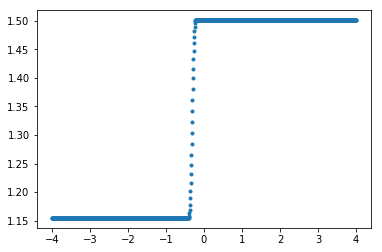

In [21]:
import numpy as np
import matplotlib.pyplot as plt

Data_numer = np.loadtxt("out1280-00000200_numer.txt")
#Data_num_2 = np.loadtxt("out2560-00000026.txt")
Data_exact = np.loadtxt("out1280-00000200_exact.txt")
#Data_exa_2 = np.loadtxt("out2560-exact.txt")

#predicted_order = 1.0
plt.figure()
#plt.plot(Data_numer[:,0],Data_numer[:,8]-Data_exact[:,8])
#plt.plot(Data_num_2[:,0],(Data_num_2[:,5]-Data_exa_2[:,5])*(2**predicted_order),'.')
plt.plot(Data_numer[:,0],Data_numer[:,5])
plt.plot(Data_numer[:,0],Data_exact[:,5],'.')
#plt.xlim(3.9,4.01)
#plt.ylim(-5.0,5.0)
plt.show()


This code will create an animation of the wave over time to hopefully show us where things go wrong.

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

globby = glob.glob('out1280-00*.txt')
file_list = []
for x in sorted(globby):
    file_list.append(x)

number_of_files = len(file_list)/2

for timestep in range(number_of_files):
    fig = plt.figure()
    numer_filename = file_list[2*timestep]
    exact_filename = file_list[2*timestep+1]
    Numer = np.loadtxt(numer_filename)
    Exact = np.loadtxt(exact_filename)
    
    plt.title("Alfven Wave")
    plt.xlabel("BU2")
    plt.ylabel("t")
    plt.xlim(-4.0,4.0)

    plt.plot(Numer[:,0],Numer[:,5])
    plt.plot(Exact[:,0],Exact[:,5],'.')
    savefig(numer_filename+".png",dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+numer_filename+"\r")
    sys.stdout.flush()

In [15]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##
# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation
!rm -f GiRaFFE_HO-1D_tests.mp4

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)/2):
    img = mgimg.imread(file_list[2*i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save('GiRaFFE_HO-1D_tests.mp4', fps=5,dpi=150)

In [16]:
%%HTML
<video width="480" height="360" controls>
  <source src="GiRaFFE_HO-1D_tests.mp4" type="video/mp4">
</video>